# Image Captioning

Observing that people who are blind have relied on (human-based) image captioning services to learn about images they take for nearly a decade, we introduce the first image captioning dataset to represent this real use case. This new dataset, which we call VizWiz-Captions, consists of 39,181 images originating from people who are blind that are each paired with 5 captions. Our proposed challenge addresses the task of predicting a suitable caption given an image. Ultimately, we hope this work will educate more people about the technological needs of blind people while providing an exciting new opportunity for researchers to develop assistive technologies that eliminate accessibility barriers for blind people (https://vizwiz.org/tasks-and-datasets/image-captioning/).

The goal of this Challenge is to create a single model similar to https://arxiv.org/pdf/1411.4555.pdf to get reasonable results on this task.

The training set contains 23431 images and 100575 captions. The validation set contains 7750 images and 33145 captions. One image can therefore have several captions. The model is trained per caption. This means that if an image has several captions (e.g. 5), then the image is also given as input 5 times in one epoch, with the according caption.

The model follows the encoder-decoder principle, where the encoder model is an already pre-trained Convolutional Neural Network (CNN) and the decoder is a long short-therm memory (LSTM) network that generates the captions. More details are described in the chapter "Model Architecture".

## Setup

First, the VizWiz API must be included according to https://github.com/Yinan-Zhao/vizwiz-caption. This includes the cloning of the repository with the inclusion of the annotation files and the download of the train and validation set, which must be unpacked in the `images` directory.

Additionally the needed packages have to be downloaded or updated. Information about the used versions can be found in `requirements.txt`.

In [1]:
#!pip3 install torch torchvision torchaudio
#!pip install tensorboard
#!pip install torchtext

In [2]:
from vizwiz_api.vizwiz import VizWiz
from vizwiz_eval_cap.eval import VizWizEvalCap
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models
from torchtext.data import get_tokenizer
from torchtext.vocab import Vocab
from torch.utils.tensorboard import SummaryWriter
from collections import Counter

import json, os, re
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

## Utility Functions

Now the access of the data, i.e. the images and the captions, must be provided. This is done by `get_alloc_dicts`, which provides some utility functions (callbacks or dictionaries) to the data set, which are very useful for preprocessing, training as well as for prediction. These include:
- `imgIdx_imgPath`: translation from image index of VizWiz API to image path
- `imgIdx_imgPath_preproc`: translation from image index of VizWiz API to image path of already preprocessed images
- `capIdx_imgIdx`: translation from caption index of VizWiz API to image index of VizWiz API
- `enumIdx_capIdx`: translation from the ascending index (0...n) of the captions to the caption index of the VizWiz API
- `capIdx_cap`: translation from the caption index of the VizWiz API to the effective caption as text
- `enumIdx_imgIdx`: translation from the ascending index (0...n) of the images to the image index of the VizWiz API
- `get_img_preproc_path`: translation from the ascending index (0...n) of the captions to the image path of the already preprocessed images
- `get_X_idx`: translation from ascending index (0...n) of captions to ascending index (0...n) of images

The functions are already prefiltered to only images which contain valid captions. So non-valid images (images without captions) do not appear in any utility function.

In [3]:
 def get_alloc_dicts(set_name, vizwiz=None):
    """Gets some utility functions for better access of the data during the preprocessing, training and prediction"""
    # be sure if `vizwiz` is set, that it contains the `set_name` dataset
    if (set_name != 'train') and (set_name != 'val') and (set_name != 'test'):
        raise Exception('only "train", "val" or "test" is a valid `set_name`')
    
    if not isinstance(vizwiz, VizWiz):
        ann_path = './annotations/'+set_name+'.json'
        vizwiz = VizWiz(ann_path, ignore_rejected=True, ignore_precanned=True)
    
    img_path_prefix = './images/'+set_name+'/'
    img_path_preproc_prefix = './images_preproc/'+set_name+'/'
    img_ids_anns = np.unique([vizwiz.anns[i]['image_id'] for i in vizwiz.anns])
    img_ids_imgs = np.unique([vizwiz.imgs[i]['id'] for i in vizwiz.imgs])
    img_ids_with_capitions = np.array([_id for _id in img_ids_imgs if _id in img_ids_anns])
    imgIdx_enumIdx = {imgIdx:idx for idx, imgIdx in enumerate(img_ids_with_capitions)}
    enumIdx_imgIdx = {idx:imgIdx for idx, imgIdx in enumerate(img_ids_with_capitions)}
    
    imgIdx_imgPath = {vizwiz.imgs[i]['id']:img_path_prefix+vizwiz.imgs[i]['file_name'] for i in vizwiz.imgs if vizwiz.imgs[i]['id'] in img_ids_with_capitions}
    imgIdx_imgPath_preproc = {vizwiz.imgs[i]['id']:img_path_preproc_prefix+vizwiz.imgs[i]['file_name'] for i in vizwiz.imgs if vizwiz.imgs[i]['id'] in img_ids_with_capitions}
    capIdx_imgIdx = {vizwiz.anns[i]['id']:vizwiz.anns[i]['image_id'] for i in vizwiz.anns}
    enumIdx_capIdx = {idx:vizwiz.anns[i]['id'] for idx, i in enumerate(vizwiz.anns)}
    capIdx_cap = {vizwiz.anns[i]['id']:vizwiz.anns[i]['caption'] for i in vizwiz.anns}
    
    def get_img_preproc_path(idx):
        capIdx = enumIdx_capIdx[idx]
        imgIdx = capIdx_imgIdx[capIdx]
        imgPath = imgIdx_imgPath_preproc[imgIdx]
        return imgPath
    
    def get_X_idx(idx):
        capIdx = enumIdx_capIdx[idx]
        imgIdx = capIdx_imgIdx[capIdx]
        X_idx = imgIdx_enumIdx[imgIdx]
        return X_idx
        
    return imgIdx_imgPath, imgIdx_imgPath_preproc, capIdx_imgIdx, enumIdx_capIdx, capIdx_cap, enumIdx_imgIdx, get_img_preproc_path, get_X_idx

Now we load these functions for the train and testset.

In [4]:
ann_train = './annotations/train.json'
vizwiz_train = VizWiz(ann_train, ignore_rejected=True, ignore_precanned=True)
imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, capIdx_imgIdx_train, enumIdx_capIdx_train, \
capIdx_cap_train, enumIdx_imgIdx_train, get_img_preproc_path_train, get_X_idx_train = get_alloc_dicts('train', vizwiz_train)

ann_val = './annotations/val.json'
vizwiz_val = VizWiz(ann_val, ignore_rejected=True, ignore_precanned=True)
imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, capIdx_imgIdx_val, enumIdx_capIdx_val, \
capIdx_cap_val, enumIdx_imgIdx_val, get_img_preproc_path_val, get_X_idx_val = get_alloc_dicts('val', vizwiz_val)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created! imgs = 23431, anns = 100575
loading annotations into memory...
Done (t=0.11s)
creating index...
index created! imgs = 7750, anns = 33145


## Preprocessing

Now I define the preprocessing of the images, which is done in the function `preprocess`. The preprocessing includes the following steps:
- `transforms.Resize`: Transforms all images to 256 x 256, this reduces the memory and computational requirements and unifies the processing of the CNN network.
- `transforms.CenterCrop`: Crops the given image at the center with a size of 224 x 224.
- `transforms.ToTensor`: Transforms a Numpy or PIL image ((H x W x C) with values from 0-255) to a torch.tensor with the shape (C x H x W) and brings the values between 0-1.
- `transforms.Normalize`: Normalizes the values of each RGB channel with a standard scaler. The values come from the `ImageNet` dataset and assume a scaling between 0-1, which were made with `transforms.ToTensor`.

In [5]:
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

to_pil = transforms.Compose([transforms.ToPILImage()])

Since we have defined the preprocessing, we can now apply it to the dataset. I have decided to preprocess the images, so that 1. the loading of the images is faster and 2. after loading the preprocessing does not have to be done. For this the datasets are stored in the folder `images_preproc` with the help of the function `preprocess_imgs`. This is especially important if you don't have enough memory for the whole train and validation dataset, so the images can only be loaded in lazy mode.

In [6]:
def preprocess_imgs(imgIdx_imgPath, imgIdx_imgPath_preproc, preprocess):
    """Preprocesses all images from ./images and stores them in ./images_preproc"""
    if not os.path.isdir('./images_preproc'):
        os.mkdir('./images_preproc')
    if not os.path.isdir('./images_preproc/train'):
        os.mkdir('./images_preproc/train')
    if not os.path.isdir('./images_preproc/val'):
        os.mkdir('./images_preproc/val')
    if not os.path.isdir('./images_preproc/test'):
        os.mkdir('./images_preproc/test')
    
    for i in imgIdx_imgPath:
        img = preprocess(Image.open(imgIdx_imgPath[i]))
        torch.save(img, imgIdx_imgPath_preproc[i])
        
# uncomment if a set is not preprocessed yet
#preprocess_imgs(imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, preprocess)
#preprocess_imgs(imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, preprocess)

If enough memory is available, the images can be loaded directly and saved as a tensor. This is done by `load_imgs`, which is used later in the DataLoader, if the setup was created this way.

In [7]:
def load_imgs(imgIdx_imgPath_preproc):
    """Loads all images in memory for eager loading setup instead of lazy,
    it assumes that `preprocess_imgs` is already done with the set u want to load"""
    imgs = []
    for i in imgIdx_imgPath_preproc:
        img = torch.load(imgIdx_imgPath_preproc[i])
        imgs.append(img)
    imgs = torch.stack(imgs, 0)
    return imgs

Now let's look at a small example of an image from the training set and its caption.

caption: ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS THE NET WEIGHT TOO.


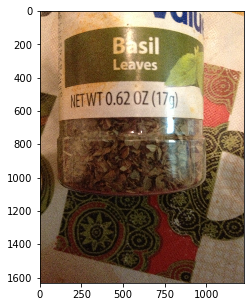

In [8]:
cap1_idx = enumIdx_capIdx_train[0]
cap1 = capIdx_cap_train[cap1_idx]
print('caption:', cap1)
img1_idx = capIdx_imgIdx_train[cap1_idx]
img1 = Image.open(imgIdx_imgPath_train[img1_idx])
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1)

The caption is in uppercase, which means that we will have to make them all lowercase later so that we don't have too many words in the vocabulary that have the same meaning. The quality of this image seems to be very good.

Now I show the same image as it looks after preprocessing.

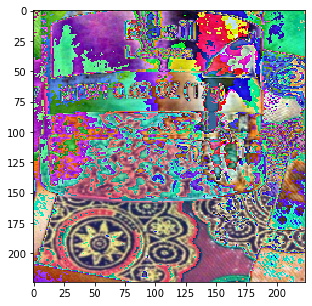

In [9]:
img1_processed = preprocess(img1)
img1_processed_pil = to_pil(img1_processed)
_ = plt.figure(figsize=(7,5))
_ = plt.imshow(img1_processed_pil)

All preprocessing steps are recognizable. The image is no longer compatible for the human eye, but it is for the model.

## Vocabulary

For the model I use a custom Word Embedding, which requires the definition of a vocabulary. Some of the captions have special characters like brackets, commas and others, which I don't want to have in my vocabulary. I remove these special characters with `rm_special_chars`. I defined the vocabulary size to 10000 words, which occur most often in the captions in the trace dataset. This includes three special characters "beginning of sentence" '\<bos>', "end of sentence" '\<eos>' and a padding '\<pad>'. Thus, all words occurring in the vocabulary have an index between 0-9999. A standard tokenizer from pytroch was used as tokenizer. All letters were converted to lower case, because there are captions where there are differences in upper and lower case, although both words have the same semantic meaning. The vocabulary is built on the trainset in `build_vocab`.

In [10]:
rm_special_chars = lambda s: re.sub(r'[^a-zA-Z0-9 ]', '', s)

def build_vocab(capIdx_cap_train, size=10000):
    """Builds the vocabular from the captions"""
    size -= 3 # -3 to address specials
    tokenizer = get_tokenizer('basic_english')
    counter = Counter()
    for i in capIdx_cap_train:
        sentence = capIdx_cap_train[i]
        sentence = rm_special_chars(sentence)
        counter.update(tokenizer(sentence.lower()))

    top_tokens = list(dict(counter.most_common(size)).keys())
    drop_tokens = list(set(counter.keys()) - set(top_tokens))
    for drop_token in drop_tokens: # drops all `drop_tokens` from `counter`
        counter.pop(drop_token)

    vocab = Vocab(counter, specials=['<bos>','<eos>','<pad>'])
    
    return tokenizer, vocab

tokenizer, vocab = build_vocab(capIdx_cap_train, size=10000)

For simplicity a maximum sentence length is defined. This has the advantage that the model does not necessarily stop after a '\<eos>' token, and the model can be trained relatively easily using batches. To define an acceptable sentence length it is important to know the percentiles of the sentence lengths, for which `get_sentence_lengths_quantiles` can be used.

In [11]:
def get_sentence_lengths_quantiles(capIdx_cap, tokenizer, vocab):
    lengths = []
    for i in capIdx_cap:
        sentence = capIdx_cap[i]
        sentence = rm_special_chars(sentence)
        sentence_tokenized = [vocab[token] for token in tokenizer(sentence.lower())] # filters the words not included in the vocabulary
        sentence_tokenized = list(filter(None, sentence_tokenized))
        lengths.append(len(sentence_tokenized))
    return np.quantile(lengths, [.5,.75,.9,.95,.99,.995,1])

# uncomment if u wanna show quantiles of the sentence lengths
get_sentence_lengths_quantiles(capIdx_cap_train, tokenizer, vocab)

array([11., 13., 17., 20., 28., 32., 95.])

In [12]:
max_sentence_length = 20

I decided to use the 95 percentile. 

Since I have not defined a '\<unknown>' token for words outside the vocabulary (because I don't want '\<unknown>' to be trained nor predicted), they have to be removed from the training as well as the validation set. After removing the unknown words, the captions > `max_sentence_length` have to be cut. After that, a '\<bos>' token is introduced at the beginning of each caption and a '\<eos>' token at the end of each caption to define the beginning and end of a caption. For captions < `max_sentence_length` the difference is padded with the special padding token '\<pad>' so that all captions have the same length for training, which simplifies batching. However, the paddings should not be included in the cost function (otherwise the model would learn to predict many '\<pad>' tokens). For this, the caption lengths must be calculated and stored without the paddings. All these steps are done in `process_sentences` and applied to the train set as well as the validation set.

In [13]:
def process_sentences(capIdx_cap, tokenizer, vocab, max_sentence_length):
    """
    Processes the captions so that only words in `vocab` remain and cut them to `max_sentence_length`.
    Sets a beginning of sentence token <bos> at the start of the tokenized sentence, continued by the tokenized sentence.
    Sets a end of sentence token <eos> at the end of the sequence and fills the rest with padding tokens <pad>
        if the length of the tokenized sentence is less than `max_sentence_length`.
    It returns the indexes of the tokenized and sequences of the vocabulary as torch.tensor and the caption_lengths as list
    """
    y = []
    cap_lengths = []
    for i in capIdx_cap:
        sentence = capIdx_cap[i]
        sentence = rm_special_chars(sentence)
        sentence_tokenized = [vocab[token] for token in tokenizer(sentence.lower())] # tokenizes the sentence and put words not in vocab to None
        sentence_tokenized = list(filter(None, sentence_tokenized))[:max_sentence_length] # filter None (not in vocab) from sentence and slice to max_sentence_length
        cap_length = len(sentence_tokenized)
        cap_lengths.append(cap_length + 2) # +2 is to address '<bos>' and '<eos>'
        max_length_diff = max_sentence_length - cap_length # calculates the numbers of '<pad>' at the start of the sentence
        sentence_tokenized = np.array([vocab['<bos>']]+sentence_tokenized+[vocab['<eos>']]+[vocab['<pad>']]*max_length_diff)
        y.append(sentence_tokenized)
        
    y = np.array(y)
    
    return torch.from_numpy(y), cap_lengths
    
y_train, train_lengths = process_sentences(capIdx_cap_train, tokenizer, vocab, max_sentence_length)
y_val, val_lengths = process_sentences(capIdx_cap_val, tokenizer, vocab, max_sentence_length)

## Data Loader

Pytorch requires a dataset class (here `ImageCaptioning`) which inherits from `Dataset`. The instance of this class can be used to create a `DataLoader` class (see "Model Training"). The constructor takes the required variables and stores them. Using `__len__` the range of indexes is defined, which are used via `__getitem__` to load the data.

I implemented two different variants in my Dataloader class. The first variant is a lazy loader, which loads the images directly from the disk before each training loop. This is for when there is not enough memory to load the whole dataset at once (as is the case on my local machine). For this `get_img_fun` must contain the utility callback function `get_img_preproc_path`, which was defined above.

The second variant loads the dataset directly into memory as a tensor. This allows to execute the epochs much faster. In order to load the data eagerly, `get_img_fun` must contain the utility callback function `get_X_idx`. This calls `load_imgs` when the dataloader class is instantiated, which loads all the already preprocessed images into `X`.

I trained the model on an external cluster where I had enough memory available. So I used the lazy function locally and the eager function remotely.

In [14]:
class ImageCaptioning(Dataset):
    def __init__(self, get_img_fun, preprocess, y, cap_lengths, load_imgs=None, imgIdx_imgPath_preproc=None):
        self.get_img_fun = get_img_fun
        self.get_img_fun_name = get_img_fun.__name__
        self.preprocess = preprocess
        self.y = y.long()
        self.cap_lengths = cap_lengths
        if self.get_img_fun_name == 'get_X_idx':
            self.X = load_imgs(imgIdx_imgPath_preproc)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.get_img_fun_name == 'get_img_preproc_path': # lazy loader
            img = torch.load(self.get_img_fun(idx))
        elif self.get_img_fun_name == 'get_X_idx': # eager loader
            img = self.X[self.get_img_fun(idx)]
        cap = self.y[idx]
        cap_length = self.cap_lengths[idx]
        return img, cap, cap_length

In [15]:
data_train = ImageCaptioning(get_img_preproc_path_train, preprocess, y_train, train_lengths)
data_val = ImageCaptioning(get_img_preproc_path_val, preprocess, y_val, val_lengths)

# uncomment if eager instead of lazy img-loading is desired
#data_train = ImageCaptioning(get_X_idx_train, preprocess, y_train, train_lengths, load_imgs, imgIdx_imgPath_preproc_train)
#data_val = ImageCaptioning(get_X_idx_val, preprocess, y_val, val_lengths, load_imgs, imgIdx_imgPath_preproc_val)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Model Architecture

The model consists of a CNN encoder `ImgCapEncoderCNN` and a LSTM decoder `ImgCapDecoderLSTM` part, which I combine under `ImgCapNet`.

### ImgCapEncoderCNN

The encoder part consists of a pretrained CNN `resnet18` (see https://arxiv.org/abs/1512.03385), which was trained to predict 1000 classes for image classification. Since image captioning does not require image classification, but the hidden features of the network, the fully-connected layer `resnet18.fc` is replaced by a custom Linear Layer. The output dimension is reduced to the input size of the LSTM network (in my case `embedding_dim`), followed by a BattchNorm Layer. The weights of the already defined layers of `resnet18` are not further adjusted during the training. Thus, the CNN part is integrated into the model in the sense of transfer learning.

### ImgCapDecoderLSTM

The decoder LSTM takes as input the output vector of the encoder. The input as well as output dimension of the LSTM I defined as `embedding_dim` (intuition follows later). The output of every iteration of the LSTM is a vector, which is followed by a Linear Layer transformation to the dimension of the vocabulary `vocab_size`. Now we have a vector which defines the probabilities of membership in the vocabulary (if trained with Softmax during training). Now that we have a classification task on the classes of the vocabulary, we can use CrossEntropyLoss (Pytorch unifies CELoss & Softmax) to define the cost function of the model and use Gradient Descent to optimize the weights. Now we take the word with the maximum probability (argmax) as the word that was predicted. To get back to the input dimension of the LSTM, an Embedding Layer is used, which transforms the vectors of the vocabulary into the 'embedding_dim'. This is used again as input for the next LSTM iteration. Now we distinguish 2 different cases where the input of the embedding layer comes from:

- mode=='train': During training, we give the ground truth as input to the embedding layer, even if the output of the last iteration predicted a different word. The output of this is then used as the input of the LSTM. This should massively speed up the learning process, since the model does not learn false conclusions from the first few (probably false) predictions. Especially because at the beginning of the training the first predictions are as good as always wrong. Thus the end of a sentence would be learned correctly only if all previous predictions were correct.

- mode=='test'|'predict': Here we do not know the captions. Thus, the most probable word of the previous iteration is given as an index into the Embedding Layer as input. The output of this is then used as input of the next LSTM iteration.

Intuition of the LSTM matrix `embedding_dim` x `embedding_dim`: The input dimension is defined as `embedding_dim`, because we use the previous word as input for the next prediction after the Embedding Layer. The output dimension could be different. However, since we transform directly to the `vocab_size` with the linear layer, the output of the LSTM should represent a word in a low dimensional space. If the Embedding Layer's output is the same as the LSTM's output, both should be word representations in the same space. Thus, after the LSTM, the Linear Layer can be viewed as the inverse of the Embedding Layer. Furthermore, I think that under this assumption, pre-trained word embedding with reduced vocabulary can also be used (i.e., remove those column vectors of embedding that do not appear in the defined vocabulary). This should be possible since embeddings use one-hot vectors and a multiplication is only a representation of a column vector. After that, in the sense of 'AutoEncoder', the decoder matrix can be trained in the reduced vocabulary, which after training can be used as a Linear Layer according to the LSTM. The Word Embedding as well as the Decoder Matrix can be frozen for training afterwards. I think that this approach could improve the image captioning task.

### ImgCapNet

This class combines `ImgCapEncoderCNN` and `ImgCapDecoderLSTM`. Furthermore, `forward` does the re-indexing of the images and captions, since `packed_padded_sequence` requires the lengths of the captions in descending order.

In [16]:
class ImgCapEncoderCNN(nn.Module):
    """Pretrained ResNet18 with altered .fc layer"""
    def __init__(self, embedding_dim):
        super(ImgCapEncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1] # deletes the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embedding_dim)
        self.bn = nn.BatchNorm1d(embedding_dim, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            out = self.resnet(images)
        out = out.reshape(out.size(0), -1)
        out = self.bn(self.linear(out))
        return out

class ImgCapDecoderLSTM(nn.Module):
    """LSTM Decoder with built-in Word Embedding"""
    def __init__(self, embedding_dim, vocab_size, max_sentence_length):
        # embedding_dim=128, vocab_size=10000, max_sentence_length=20
        super(ImgCapDecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.inv_embedding = nn.Linear(embedding_dim, vocab_size)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim)
        
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_sentence_length = max_sentence_length + 2 # +2 to cover the added <bos> and <eos>
    
    def forward(self, x, y=None, mode='pred'):
        """
        `mode` describes how the forward propagation is defined:
            - 'pred': During prediction, the argmax word of the previous prediction is given and it returns the argmax prediction
            - 'train': During training, the true label `y[:,i]` is provided as input for the next prediction and it returns the predicted vector in the vocabulary space
            - 'test': During testing, the argmax word of the previous prediction is given and it returns the predicted vector in the vocabulary space
        """
        out = []
        hidden = None
        for i in range(self.max_sentence_length):
            output, hidden = self.lstm(x.unsqueeze(0), hidden)
            output = output.squeeze(0)
            y_pred = self.inv_embedding(output)
            if mode == 'pred':
                _, predicted = y_pred.max(1)
                out.append(predicted)
            elif mode == 'train':
                predicted = y[:,i] # takes the true word as input for training
                out.append(y_pred)
            elif mode == 'test':
                _, predicted = y_pred.max(1)
                out.append(y_pred)
            x = self.embedding(predicted)
        out = torch.stack(out, 1)
        return out
    
class ImgCapNet(nn.Module):
    """ImgCapNet combines ImgCapEncoderCNN and ImgCapDecoderLSTM in one class"""
    def __init__(self, embedding_dim, vocab_size, max_sentence_length):
        super(ImgCapNet, self).__init__()
        self.ImgCapEncoderCNN = ImgCapEncoderCNN(embedding_dim)
        self.ImgCapDecoderLSTM = ImgCapDecoderLSTM(embedding_dim, vocab_size, max_sentence_length)
        
    def forward(self, x, y=None, cap_lens=None, mode='pred'):
        """During `mode`=='train'|'test', `pack_padded_sequence` requires sorted captions"""
        x1 = self.ImgCapEncoderCNN(x)
        if (mode == 'train') or (mode == 'test'):
            cap_lens, sort_ind = cap_lens.sort(dim=0, descending=True)
            x1 = x1[sort_ind]
            if mode == 'train':
                y = y[sort_ind]
        x2 = self.ImgCapDecoderLSTM(x1, y, mode)
        
        if (mode == 'train') or (mode == 'test'):
            return x2, cap_lens.tolist(), sort_ind # if `cap_lens` is not transformed to list, then `pack_padded_sequence` can't work on the gpu
        elif mode == 'pred':
            return x2

## Training

Now we come to the training of the model. To have the storage management of the models as well as the tracking of the iterations even after an interruption under control, I have implemented some utility functions. The setup is made so that I can enter a model number in `model_num`, and then the corresponding model including its weights and training iterations can be loaded if available.

`save_iter`: Stores the tracking of the iterations of the models.

`get_iter`: Loads or initializes (if not available) the JSON for tracking the iterations.

`get_iter_value`: Loads the desired iteration if available, or initializes it directly to 0 if not exists.

`save_model`: Saves the weights of the model in the `models` directory.

`get_model`: Loads the weights of an already saved model into the given model, if it exists.

In [17]:
def save_iter(json_):
    with open('iter.json', 'w') as fp:
        json.dump(json_, fp)
        
def get_iter():
    path = 'iter.json'
    if os.path.exists(path):
        with open(path, 'r') as fp:
            json_ = json.load(fp)
    else:
        json_ = dict()
    return json_

def get_iter_value(json_, key, model_name):
    if (key not in json_) or (not os.path.exists('./models/'+model_name+'.pth')):
        json_[key] = 0
    return json_[key]

def save_model(model, model_name):
    path = './models/'+model_name+'.pth'
    torch.save(model.state_dict(), path)
    
def get_model(model, model_num):
    """Loads the stored weights if it exists
       If the model doesn't exists yet, then just the given `model` will be returned"""
    path = './models/model_'+str(model_num)+'.pth'
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
    model.eval()
    return model

Now an instantiated `ImgCapNet` can be trained using `train_model`. For this, the instantiated `ImgCapNet` is passed as `model`, and the `ImageCaptioning` instantiated with the train and test set as `data_train` and `data_test`. In addition, the `batch_size` and the `lr` can be chosen. As `optimizer` I've chosen to use `Adam`. I track the `batch_loss`, `train_loss` as well as the `test_loss` using tensorboard, which can be started in the root directory by "tensorboard --logdir=runs".

The cost function is pytroch's `CrossEntropyLoss`, which combines `CELoss` and `Softmax` in one class. It is important here that the paddings '\<pad>' are not included in the cost function, otherwise the model will only learn '\<pad>' if they are reasonably frequent (which is the case for a sentence length of 20). To avoid this, the function `pack_padded_sequence` is used, which makes a cut of the output tensor `logits` and the captions `targets` as well as a rollout using the provided length of the captions without the paddings.

After each epoch the model is saved and can be loaded for later use. Unfortunately it is not possible to introduce an early stopping with the help of `test_loss`, because the `test_loss` gets only bigger and bigger during training. So I have no direct control when and if the model overfits. It would be possible with a score like BELU. However, this is not in the scope of this work.

The training of the model was done on CSCS, where I had enough resources to train the model performantly.

In [18]:
def train_model(model, data_train, data_test, batch_size, lr, n_epochs, model_num, save_by_interrupt=True):
    model_name = 'model_'+str(model_num)
    iter_name = 'iter_'+str(model_num)
    iter_name_test = 'iter_test_'+str(model_num)
    iter_name_batch = 'iter_batch_'+str(model_num)
    
    dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    iter_json = get_iter()
    n_iter = get_iter_value(iter_json, iter_name, model_name)
    n_iter_test = get_iter_value(iter_json, iter_name_test, model_name)
    n_iter_batch = get_iter_value(iter_json, iter_name_batch, model_name)
    writer = SummaryWriter('./runs/'+model_name)
    
    try:
        for epoch in range(n_epochs):
            train_loss, test_loss = 0, 0
            # train_loops
            model.train()
            for imgs, caps, caplens in dataloader:
                imgs = imgs.to(device)
                caps = caps.to(device)
                caplens = caplens.to(device)
                
                logits, lengths, sort_ind = model(imgs, y=caps, cap_lens=caplens, mode='train')
                targets = caps[sort_ind]
                # pack_padded_sequence is to not take <pad> into account during training, otherwise the network would learn to add too many <pad> to the output
                scores = pack_padded_sequence(logits, lengths, batch_first=True)[0]
                targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
                loss = loss_fn(scores, targets)
                
                with torch.no_grad():
                    batch_loss = loss.item()
                    writer.add_scalar('batch_loss', batch_loss, n_iter_batch) # track minibatch_loss
                    n_iter_batch += 1
                    iter_json[iter_name_batch] = n_iter_batch
                    minibatch_ratio = imgs.shape[0] / dataloader.batch_size # correction of contribution of batch_loss to train_loss of the last batch
                    train_loss += batch_loss * minibatch_ratio

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(dataloader)
            writer.add_scalar('train_loss', train_loss, n_iter)
            n_iter += 1
            iter_json[iter_name] = n_iter
            
            # test_loops
            model.eval()
            with torch.no_grad():
                for imgs, caps, caplens in dataloader_test:
                    imgs = imgs.to(device)
                    caps = caps.to(device)
                    caplens = caplens.to(device)
                    
                    logits, lengths, sort_ind = model(imgs, cap_lens=caplens, mode='test')
                    targets = caps[sort_ind]
                    # pack_padded_sequence is to not take <pad> into account during training, otherwise the network would learn to add too many <pad> to the output
                    scores = pack_padded_sequence(logits, lengths, batch_first=True)[0]
                    targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
                    loss = loss_fn(scores, targets)
                    
                    minibatch_ratio = imgs.shape[0] / dataloader_test.batch_size
                    test_loss += loss.item() * minibatch_ratio
                    
                test_loss /= len(dataloader_test)
                writer.add_scalar('test_loss', test_loss, n_iter_test) # uses n_iter_test in case the KeyboardInterrupt occurs during test_loops
                n_iter_test += 1
                iter_json[iter_name_test] = n_iter_test
            
            # stores `iter_json` & `model` after each epoch or a KeyboardInterrupt occured and `save_by_interrupt` is set to True
            print('epoch: '+str(epoch)+'    train_loss: '+str(train_loss)+'    test_loss: '+str(test_loss), flush=True)
            save_iter(iter_json)
            save_model(model, model_name)
    except KeyboardInterrupt:
        if save_by_interrupt:
            save_iter(iter_json)
            save_model(model, model_name)
            print('\nKeyboardInterrupt, iter_json and model saved')

Here I instantiate the model `ImgCapNet` with the defined `model_num` to provide the model for training and/or evaluation.

In [19]:
model_num = 4
icn = ImgCapNet(128, len(vocab), max_sentence_length)
icn = get_model(icn, model_num).to(device) # loads already trained parameters of the model if model_num is available

In [20]:
# uncomment if training of the model is desired
#train_model(model=icn, data_train=data_train, data_test=data_val, batch_size=64, lr=.0001, n_epochs=5, model_num=model_num, save_by_interrupt=True)

<img src="loss.png" width="900" align="left">

Shown here are `batch_loss`, `train_loss` and `test_loss` of `model_num` 4. I trained this network over 120 epochs with a `batch_size` of 64 and an `lr` of 0.0001. The batch_loss as well as the train_loss runs according to my expectations. Special however is the test_loss. It increases steadily, although the captions became better and better (test after 1 and 20 epochs). I think that the test_loss is too focused on one word at exactly one position in the sentence, and thus is not suitable for an evaluation of the model. As mentioned above, other metrics such as BELU would have to be considered.

## Model Evaluation

Since I don't have a score for the evaluation, I'm doing it based on some examples that are mainly doing on the validation set. The displayed caption is always only the predicted one, i.e. never the ground truth, no matter if in the train or test set.

In [21]:
def eval_img(model, enumIdx_imgIdx, imgIdx_imgPath, imgIdx_imgPath_preproc, vocab, idx):
    get_word = lambda idx: vocab.itos[idx]
    model = model.to('cpu')
    model.eval()
    imgIdx = enumIdx_imgIdx[idx]
    img_pred = torch.load(imgIdx_imgPath_preproc[imgIdx])
    
    pred = model(img_pred.unsqueeze(0))[0]
    pred_sentence = [get_word(word) for word in pred]
    pred_sentence = ' '.join(pred_sentence)
    print(pred_sentence)
    
    img = Image.open(imgIdx_imgPath[imgIdx])
    _ = plt.figure(figsize=(7,5))
    _ = plt.imshow(img)

### Evaluation Train Set

<bos> a computer screen with a captcha on it <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


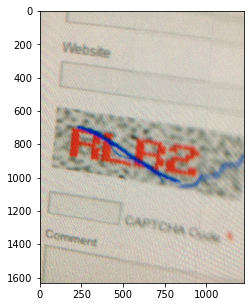

In [22]:
eval_img(icn, enumIdx_imgIdx_train, imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, vocab, 834)

<bos> a package of frozen food is on top of a table <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


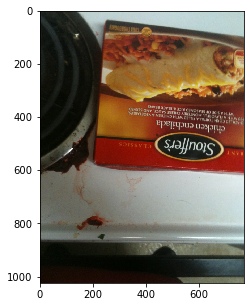

In [23]:
eval_img(icn, enumIdx_imgIdx_train, imgIdx_imgPath_train, imgIdx_imgPath_preproc_train, vocab, 19853)

As you can see, the predicted captions of the training set can describe the corresponding image very well. I am surprised that the model learns to append only '\<eos>' tokens at the end, although the captions have only one such token at the end. However, this illustration only shows that the algorithm works and nothing else. Therefore, we continue the evaluation with the test set.

### Evaluation Test Set

<bos> a can of food is on top of a table <eos> in a kitchen <eos> <eos> <eos> <eos> <eos> <eos> <eos>


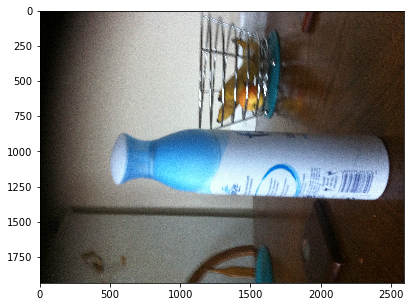

In [24]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 1353)

Here, the prediction is already not so accurate. Nevertheless, a somewhat reasonable sentence appears with somewhat reasonable content. The content of the pot is also hard to see and since it has Food in the background, it could have made this association. Here you can also see a '\<eos>' token in the middle of the sentence.

<bos> a box of food is on top of a table <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


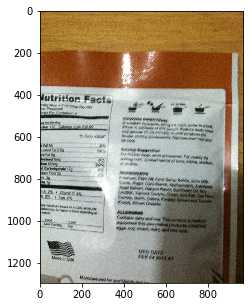

In [25]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 2178)

This is an almost perfect prediction. This is most likely because these types of images are rather common in the train set.

<bos> a tv screen is on a wooden entertainment center <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


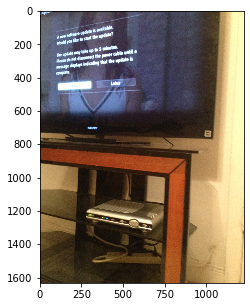

In [26]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 742)

Again, we have a prediction that I consider to be very good.

<bos> a phone screen with a black screen with a white cord on it <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


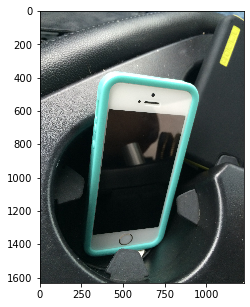

In [27]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 5425)

Here most of the sentence is correct. It captured some cell phone with a screen. In my opinion, this could indicate overfitting, if the model learns more or less fixed sentences on the most fitting images. But I can't say exactly.

<bos> a computer screen is displaying a window with a message <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


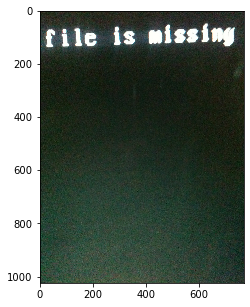

In [28]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 3852)

With this simple image the model gets a perfect prediction. I've seen this type of image very often in the training set, so the good prediction is not surprising.

<bos> a bag of chips is on a table <eos> in a persons hand <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


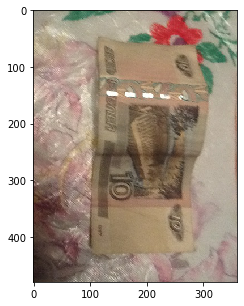

In [29]:
eval_img(icn, enumIdx_imgIdx_val, imgIdx_imgPath_val, imgIdx_imgPath_preproc_val, vocab, 6218)

To be fair, I was a little selective in choosing the images on the test set (although not very). It also has some images in it which had rather poor to very poor captions as output. This image is an example of that.

### Evaluation Custom Set

This is a self-made photo on which I perform a prediction.

<bos> a person is holding a statue of a man in a room with a chair and a dog on the floor


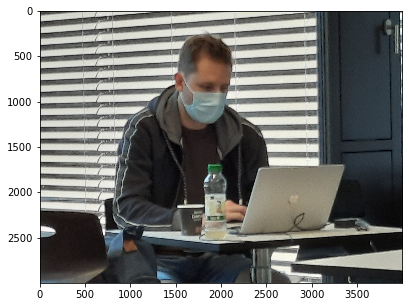

In [30]:
def custom_img(model, vocab, preprocess, path):
    get_word = lambda idx: vocab.itos[idx]
    model = model.to('cpu')
    model.eval()
    img = Image.open(path)
    img_processed = preprocess(img)
    
    pred = model(img_processed.unsqueeze(0))[0]
    pred_sentence = [get_word(word) for word in pred]
    pred_sentence = ' '.join(pred_sentence)
    print(pred_sentence)
    
    _ = plt.figure(figsize=(7,5))
    _ = plt.imshow(img)
    
custom_img(icn, vocab, preprocess, './custom_images/custom_1.jpg')

Here the prediction already looks very inaccurate. However, some fragments are included which are valid, such as 'person', 'man', 'room' and 'chair'. Nevertheless, the caption leaves much to be desired. I assume that the description is not very good because the trainset contains few images of this kind (as far as I have seen the images).

## Conclusion

The model is capable of making simple descriptions on comparatively simple images, provided they are in the training set. The model could clearly be improved by using beam search for prediction or by having a validation score. Also with increasing size of the data set, which justifies an increase of the vocabulary, I would expect better descriptions. Another possibility I mentioned in "Model Architecture" is the inclusion of a pre-trained word embedding (although I don't know if this would actually work). Furthermore, there are certainly other techniques for state of the art models, which I do not know. I am happy with the result and have learned a lot about Deep Learning.